In [3]:
import os
import jax
import sys
import numpy as np
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

ModuleNotFoundError: No module named 'modeling_hybrid_clip'

In [2]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


In [3]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [6]:
jax.device_count()

1

In [4]:
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [19]:
import os

img_dir = "/home/kaushalya/downloads/roco-dataset/data/test/radiology/images"

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "PMC4582529_JoU-2012-0014-g020.jpg"
caption = " Plain X-ray of the abdomen showing a well-defined, rounded soft tissue density mass, in the central abdominal region with calcification (arrows)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)

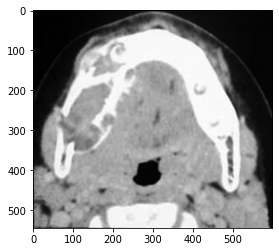

In [21]:
# Let's load a sample image
import os
img = Image.open(os.path.join(img_dir, img_path))
plt.imshow(img, aspect='equal', cmap='gray')

In [239]:
class Transform(torch.nn.Module):
    def __init__(self, image_size=224):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size, image_size], interpolation=InterpolationMode.BICUBIC),
            ConvertImageDtype(torch.float),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
        return x

In [9]:
sentences = [f'{c} with' for c in classes]
print(sentences)

['man with', 'woman with']


In [308]:
img_transforms = Transform()
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
outputs = model(**inputs)

In [11]:
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)

In [14]:
outputs = model(**inputs)

In [15]:
outputs.logits_per_image.shape

(1, 2)

In [16]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

man with: 0.46
woman with: 0.54


In [1]:
query = 'carcinoma'
img_list = os.listdir(img_dir)[10:20]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
outputs = model(**inputs)

NameError: name 'img_dir' is not defined

In [314]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

PMC2740232_1757-1626-0002-0000008474-003.jpg: 0.08
PMC1665243_ci05016705.jpg: 0.11
PMC3697197_JPBS-5-166-g003.jpg: 0.09
PMC4137701_CRIRA2014-614846.001.jpg: 0.10
PMC29044_cc-4-4-245-1.jpg: 0.10
PMC3789894_wjem-14-411-g001.jpg: 0.13
PMC1665243_ci05016711.jpg: 0.07
PMC4520145_dpjo-20-03-00101-gf07.jpg: 0.09
PMC1592293_1749-8090-1-29-1.jpg: 0.13
PMC4797165_13256_2016_848_Fig1_HTML.jpg: 0.09


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])